In [28]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [29]:
# 경로 설정
import os
os.chdir('/content/gdrive/MyDrive/2021/Finger-Print Classification')

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import tensorflow as tf
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

In [3]:
def data_info(direct):
  files = [file.strip() for file in os.listdir('./'+direct)]  # 디렉토리 안에 있는 이미지들의 이름
  filenames = []     
  for file in files:            # 파일명, 클래스 분류
    add = [file[:-4],file[0]]   # 파일명과 인덱스(파일명의 첫 번째 값) 반환
    filenames.append(add)
  return filenames

In [4]:
# train, test 데이터의 파일명 담은 dataframe 생성
df_train = data_info(direct = 'train')
df_test = data_info(direct = 'test')

# 데이터프레임 생성
train = pd.DataFrame(df_train, columns =['filename', 'label']) 
test = pd.DataFrame(df_test, columns = ['filename', 'label'])   # test data에서 label 값 의미 없는 값(실제 라벨 값 아님) -> predict 후 바꿔줄것
display(train.head(), test.head())

,filename,label
0,1 (1),1
1,1 (10),1
2,1 (2),1
3,1 (3),1
4,1 (4),1


,filename,label
0,1,1
1,10,1
2,11,1
3,12,1
4,13,1


In [5]:
def pixel_info(direct, df):
  pixels = []
  for file in list(df['filename']):  # 각 이미지에 대해
    from PIL import Image
    im = Image.open('./'+direct+'/'+file+'.bmp')  # 이미지 불러오기
    pix = list(im.getdata())   # 각 이미지 픽셀값 계산
    pixels.append(pix)

  df_pix = pd.DataFrame(pixels, columns = list(range(144**2)))  # pixel data 담은 dataframe
  return df_pix

In [6]:
train_pix = pixel_info('train', train)
test_pix = pixel_info('test', test)

In [35]:
display(train_pix.head(), test_pix.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,20696,20697,20698,20699,20700,20701,20702,20703,20704,20705,20706,20707,20708,20709,20710,20711,20712,20713,20714,20715,20716,20717,20718,20719,20720,20721,20722,20723,20724,20725,20726,20727,20728,20729,20730,20731,20732,20733,20734,20735
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,20696,20697,20698,20699,20700,20701,20702,20703,20704,20705,20706,20707,20708,20709,20710,20711,20712,20713,20714,20715,20716,20717,20718,20719,20720,20721,20722,20723,20724,20725,20726,20727,20728,20729,20730,20731,20732,20733,20734,20735
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


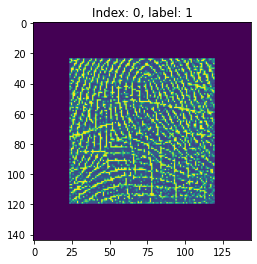

In [7]:
# 이미지 픽셀로 잘 변환되었는지 확인하기

idx = 0
img = train_pix.loc[idx, '0':].values.reshape(144, 144).astype(int)
label = train.loc[idx, 'label']

plt.title('Index: %i, label: %s'%(idx, label))
plt.imshow(img)
plt.show()

Train-Test-Split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(train_pix.values, train['label'], test_size = 0.3, random_state=42, shuffle=True, stratify=None)

X_train = X_train.reshape(-1, 144, 144, 1)
X_train = X_train/255

X_val = X_val.reshape(-1, 144, 144, 1)
X_val = X_val/255

X_test = test_pix.values.reshape(-1, 144, 144, 1)
X_test = X_test/255

# train/test label 값 one-hot-encoding
y_train_vec = np.zeros((len(y_train), 8))
for i, digit in enumerate(y_train):
    y_train_vec[int(i), int(digit)-1] = 1

y_val_vec = np.zeros((len(y_val), 8))
for i, digit in enumerate(y_val):
    y_val_vec[int(i), int(digit)-1] = 1

CNN Model

In [22]:
# ##Data Augmentation

# datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     featurewise_center=False, #set input mean to 0 over dataset
#     samplewise_center=False, #set each sample mean to 0
#     featurewise_std_normalization=False, #divide inputs by std of dataset
#     samplewise_std_normalization=False, #divide each input by its std
#     zca_whitening=False, #apply ZCA whitening
#     rotation_range=10, #randomly rotate images (10 degrees)
#     width_shift_range=0.1, #randomly shift images horizontally (10% of the width)
#     height_shift_range=0.1, #randomly shift images vertically(10% of height)
#     zoom_range=0.1, #randomly zoom image (10%)
#     horizontal_flip=False, #rahdomly flip image
#     vertical_flip=True, #randomly flip image
# )

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

# 8개의 지문으로 분류
nb_classes = 8
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)


model = Sequential([
                  Conv2D(nb_filters, kernel_size[0], kernel_size[1], padding='valid', input_shape=X_train.shape[1:], activation = 'relu'),
                  Conv2D(nb_filters, kernel_size[0], kernel_size[1], activation = 'relu'),
                  MaxPooling2D(pool_size=pool_size),
                  Dropout(0.25),

                  Flatten(),
                  Dense(128, activation = 'relu'),
                  Dropout(0.5),
                  Dense(nb_classes, activation = 'softmax')
])

In [34]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer= 'adam' , metrics=['accuracy'])

In [35]:
batch = 8
epoch = 10
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./model/model_cnn.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) # best model 저장하기

In [36]:
# augmentation 한 데이터로 train
# history = model.fit(datagen.flow(X_train, y_train_vec), 
#                     epochs= epoch, 
#                     callbacks = [es, mc],
#                     batch_size = batch,
#                     validation_data = (X_val, y_val_vec)
#                     )

history = model.fit(X_train, y_train_vec, epochs=epoch, callbacks=[es, mc], batch_size=batch, validation_data=(X_val, y_val_vec))

- val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to ./model\model_cnn.h5
Epoch 2/10
7/7 [==============================] - 0s 16ms/step - loss: 1.9282 - accuracy: 0.2857 - val_loss: 1.8635 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.50000
Epoch 3/10
7/7 [==============================] - 0s 19ms/step - loss: 1.7355 - accuracy: 0.4821 - val_loss: 1.6207 - val_accuracy: 0.8750

Epoch 00003: val_accuracy improved from 0.50000 to 0.87500, saving model to ./model\model_cnn.h5
Epoch 4/10
7/7 [==============================] - 0s 18ms/step - loss: 1.4269 - accuracy: 0.7321 - val_loss: 1.2827 - val_accuracy: 0.9583

Epoch 00004: val_accuracy improved from 0.87500 to 0.95833, saving model to ./model\model_cnn.h5
Epoch 5/10
7/7 [==============================] - 0s 19ms/step - loss: 1.1246 - accuracy: 0.8571 - val_loss: 0.8713 - val_accuracy: 1.0000

Epoch 00005: val_accuracy improved from 0.95833 to 1.00000, saving model 

In [38]:
from tensorflow.keras.models import load_model

# 모델 불러오기
best = load_model('./model/model_cnn.h5')

In [39]:
# validation data에 대해 예측한 값 리스트에 저장
val_predict = np.argmax(best.predict(X_val), axis=1)

# 예측 정확도
print("\n Validation 정확도: %.4f" % (best.evaluate(X_val, y_val_vec)[1]))
print(classification_report(np.argmax(y_val_vec, axis=1),val_predict))

1/1 [==============================] - 0s 213ms/step - loss: 0.8713 - accuracy: 1.0000

 Validation 정확도: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         2

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [40]:
test_predict = np.argmax(best.predict(X_test), axis=1)  # test 데이터에 대한 예측 진행
true_class = [pred+1 for pred in test_predict]          # test 데이터에 대한 예측 -> 인덱스 값 -> +1 해줘서 1~8까지의 label으로 변경

test['label'] = true_class                              # 예측한 라벨 값 매핑

In [41]:
test['filename'] = pd.to_numeric(test["filename"])      # filename numeric하게 바꾸기
test                                                    # 예측한 라벨값과 매핑된 결과

,filename,label
0,1,7
1,10,3
2,11,4
3,12,2
4,13,5
...,...,...
75,78,1
76,79,7
77,8,4
78,80,8


In [42]:
result = test.sort_values(by=['filename'], ascending=True)  # 파일 이름 순서대로 정렬
result.head()

,filename,label
0,1,7
11,2,8
22,3,2
33,4,4
44,5,1


In [43]:
result.to_csv('./result/result_cnn.csv', index = False)

In [44]:
# 제대로 저장되었는지 확인
result = pd.read_csv('./result/result_cnn.csv')
result.head()

,filename,label
0,1,7
1,2,8
2,3,2
3,4,4
4,5,1


In [45]:
# 각 class 당 데이터 몇 개 있는지 파악하기
from collections import Counter
Counter(result['label'])

Counter({7: 5, 8: 29, 2: 10, 4: 11, 1: 3, 5: 10, 3: 10, 6: 2})